In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

from func2graph import data, models, tools

In [3]:
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.size': 14
})

In [4]:
KK_GT = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')
max_abs = np.max(np.abs(KK_GT))
vmin_KK = -max_abs
vmax_KK = max_abs

In [7]:
input_mouse = ['SB025']
input_sessions = [['2019-10-23']]

window_size = 60  ################
batch_size = 32

train_dataloader, val_dataloader, num_unqiue_neurons, cell_type_order, all_sessions_new_cell_type_id, num_batch_per_session_TRAIN, num_batch_per_session_VAL, sessions_2_original_cell_type, neuron_id_2_cell_type_id = data.generate_mouse_all_sessions_data(
    input_mouse=input_mouse,
    input_sessions=input_sessions,
    window_size=window_size,
    batch_size=batch_size,
)

checkpoint_path = "../../output/9_26_AwC_M2_state/Attention_With_Constraint_2_SB025_2019-10-23_32_60_1_session_42_2_64_0.001_mse_softmax_plateau_0.0_0.0_1.0_none_1_0.0_30/epoch=99-step=9600.ckpt"   ################
trained_model = models.Attention_With_Constraint_2.load_from_checkpoint(checkpoint_path)
trained_model.eval()

trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

val_results = trainer.predict(trained_model, dataloaders=[val_dataloader])

predictions = []
ground_truths = []
all_R_squared = []

index = 0
num_session = len(num_batch_per_session_VAL)
for i in range(num_session):
    predictions.append([])
    ground_truths.append([])

    for j in range(num_batch_per_session_VAL[i]):
        x_hat = val_results[index][0]
        x = val_results[index][1]
        
        predictions[i].append(x_hat)
        ground_truths[i].append(x)
        index += 1
    
    predictions[i] = torch.cat(predictions[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    ground_truths[i] = torch.cat(ground_truths[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    print(predictions[i].shape, ground_truths[i].shape)
    R_squared = r2_score(ground_truths[i].reshape(ground_truths[i].shape[0], -1), predictions[i].reshape(predictions[i].shape[0], -1), multioutput='variance_weighted')
    all_R_squared.append(R_squared)

print('all_R_squared:', np.mean(all_R_squared))
print('flattened R^2', r2_score(ground_truths[0].reshape(-1), predictions[0].reshape(-1)))

mse = np.mean((predictions[0] - ground_truths[0]) ** 2)
print('mse:', mse)

SB025/2019-10-23
no normalization
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']


/home/wz1411/miniconda3/envs/func2graph/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wz1411/miniconda3/envs/func2graph/lib/python3. ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/wz1411/miniconda3/envs/func2graph/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wz1411/miniconda3/envs/func2graph/lib/python3. ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that

Predicting DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 36.47it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  338            	|  9.4618         	

(704, 527, 1) (704, 527, 1)
all_R_squared: 0.022739393636584282
flattened R^2 0.5531237125396729
mse: 0.40031987


In [ ]:
train_results = trainer.predict(trained_model, dataloaders=[train_dataloader])

predictions_TRAIN = []
ground_truths_TRAIN = []

index = 0
num_session = len(num_batch_per_session_TRAIN)
for i in range(num_session):
    predictions_TRAIN.append([])
    ground_truths_TRAIN.append([])

    for j in range(num_batch_per_session_TRAIN[i]):
        x_hat = train_results[index][0]
        x = train_results[index][1]
        
        predictions_TRAIN[i].append(x_hat)
        ground_truths_TRAIN[i].append(x)
        index += 1
    
    predictions_TRAIN[i] = torch.cat(predictions_TRAIN[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    ground_truths_TRAIN[i] = torch.cat(ground_truths_TRAIN[i], dim=0).cpu().numpy()  # N * neuron_num * window_size
    print(predictions_TRAIN[i].shape, ground_truths_TRAIN[i].shape)

    T, N, W = predictions_TRAIN[i].shape

    # train_mean: N * 1
    train_mean = np.mean(ground_truths_TRAIN[i].reshape(-1, N), axis=0)
    flattened_train_mean = np.mean(ground_truths_TRAIN[i])
    print('train_mean:', train_mean.shape)

    # for validation
    R_squared = tools.R_squared_w_trainMean(ground_truths[i].reshape(-1, N), predictions[i].reshape(-1, N), train_mean)
    print('R_squared:', R_squared)

    flattened_R_squared = tools.flattened_R_squared_w_trainMean(ground_truths[i].reshape(-1), predictions[i].reshape(-1), flattened_train_mean)
    print('flattened_R_squared:', flattened_R_squared)

### Attention

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:12, ?it/s]
Predicting DataLoader 0: 100%|██████████| 96/96 [00:02<00:00, 37.66it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  1733           	|  34.413         	

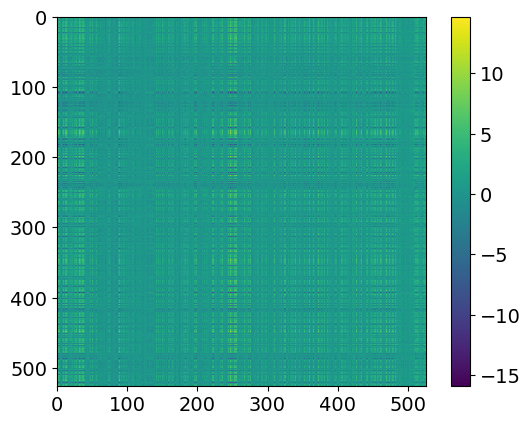

state 0:  1 (527, 527)
state 1:  1 (527, 527)
state 2:  1 (527, 527)
time_index: 1 3 710


In [9]:
train_results = trainer.predict(trained_model, dataloaders=[train_dataloader])

attentions = []  # list of (N * neuron_num * neuron_num)
all_sessions_avg_attention_NN = []  # list of (neuron_num * neuron_num)

attentions_by_state = []  # list of (3 * N * neuron_num * neuron_num)
all_sessions_avg_attention_NN_by_state = []  # list of (3 * neuron_num * neuron_num)

time_index = []  # list of (3 * N)   This is used to track the time step of each sample within a session

index = 0
num_session = len(num_batch_per_session_TRAIN)
for i in range(num_session):
    attentions.append([])
    attentions_by_state.append([[], [], []]) # 3 states for each session
    time_index.append([[], [], []])

    for j in range(num_batch_per_session_TRAIN[i]):
        x_hat = train_results[index][0]
        x = train_results[index][1]
        attention = train_results[index][2]  # B * neuron_num * neuron_num
        state = train_results[index][4].cpu().numpy()   # B * window_size

        attentions[i].append(attention)

        # check if all values in state of a sample are the same
        for k in range(state.shape[0]):
            if np.all(state[k] == state[k][0]):
                attentions_by_state[i][state[k][0]].append(attention[k])
                time_index[i][state[k][0]].append(j * batch_size + k)
        
        index += 1

    attentions[i] = torch.cat(attentions[i], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    # get average attention across samples in each session
    all_sessions_avg_attention_NN.append(np.mean(attentions[i], axis=0))   # neuron_num * neuron_num

    attentions_by_state[i][0] = torch.stack(attentions_by_state[i][0], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    attentions_by_state[i][1] = torch.stack(attentions_by_state[i][1], dim=0).cpu().numpy()    # N * neuron_num * neuron_num
    attentions_by_state[i][2] = torch.stack(attentions_by_state[i][2], dim=0).cpu().numpy()    # N * neuron_num * neuron_num

    all_sessions_avg_attention_NN_by_state.append([])
    all_sessions_avg_attention_NN_by_state[i].append(np.mean(attentions_by_state[i][0], axis=0))   # neuron_num * neuron_num
    all_sessions_avg_attention_NN_by_state[i].append(np.mean(attentions_by_state[i][1], axis=0))   # neuron_num * neuron_num
    all_sessions_avg_attention_NN_by_state[i].append(np.mean(attentions_by_state[i][2], axis=0))   # neuron_num * neuron_num

    all_sessions_avg_attention_NN_by_state[i] = np.stack(all_sessions_avg_attention_NN_by_state[i], axis=0)  # 3 * neuron_num * neuron_num

plt.imshow(all_sessions_avg_attention_NN[0])
plt.colorbar()
plt.show()

# get all avg attentions from the same state
state2all_sessions_avg_attention = [[], [], []]   # 3 * num_session * neuron_num * neuron_num
for i in range(3):
    state2all_sessions_avg_attention[i] = [all_sessions_avg_attention_NN_by_state[j][i] for j in range(num_session)]

print('state 0: ', len(state2all_sessions_avg_attention[0]), state2all_sessions_avg_attention[0][0].shape)
print('state 1: ', len(state2all_sessions_avg_attention[1]), state2all_sessions_avg_attention[1][0].shape)
print('state 2: ', len(state2all_sessions_avg_attention[2]), state2all_sessions_avg_attention[2][0].shape)

print('time_index:', len(time_index), len(time_index[0]), len(time_index[0][0]))

In [10]:
print(len(attentions_by_state))
print(len(attentions_by_state[0]))

# Just look at the first session !!!!!!!!!
print('number of attentions in state 0 of first session', attentions_by_state[0][0].shape)
print('number of attentions in state 1 of first session', attentions_by_state[0][1].shape)
print('number of attentions in state 2 of first session', attentions_by_state[0][2].shape)

# Flatten each attention matrix in a state
state0 = attentions_by_state[0][0].reshape(attentions_by_state[0][0].shape[0], -1)
state1 = attentions_by_state[0][1].reshape(attentions_by_state[0][1].shape[0], -1)
state2 = attentions_by_state[0][2].reshape(attentions_by_state[0][2].shape[0], -1)

# concartenate all states
state012 = np.concatenate([state0, state1, state2], axis=0)
label = np.concatenate([np.zeros(state0.shape[0]), np.ones(state1.shape[0]), 2 * np.ones(state2.shape[0])])
time_index012 = np.concatenate([time_index[0][0], time_index[0][1], time_index[0][2]])

print('label:', label)
print('time_index012:', time_index012.shape)

1
3
number of attentions in state 0 of first session (710, 527, 527)
number of attentions in state 1 of first session (672, 527, 527)
number of attentions in state 2 of first session (415, 527, 527)
label: [0. 0. 0. ... 2. 2. 2.]
time_index012: (1797,)


(1797, 2)


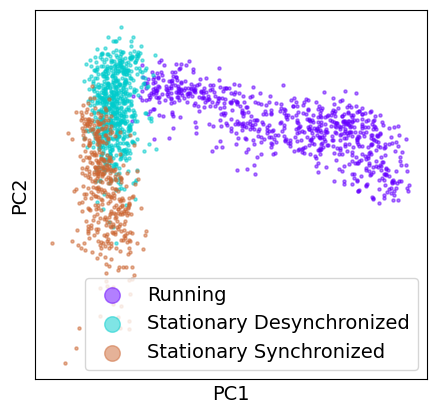

In [12]:
# do PCA on the flattened attentions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(state012)
print(X_pca.shape)

plt.scatter(X_pca[label == 0, 0], X_pca[label == 0, 1], label='Running', alpha=0.5, s=5, c='#6600FF')
plt.scatter(X_pca[label == 1, 0], X_pca[label == 1, 1], label='Stationary Desynchronized', alpha=0.5, s=5, c='#00CCCC')
plt.scatter(X_pca[label == 2, 0], X_pca[label == 2, 1], label='Stationary Synchronized', alpha=0.5, s=5, c='#CC6633')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal', adjustable='box')
# plt.title('PCA on Attention Maps')
plt.legend(markerscale=5)
plt.show()

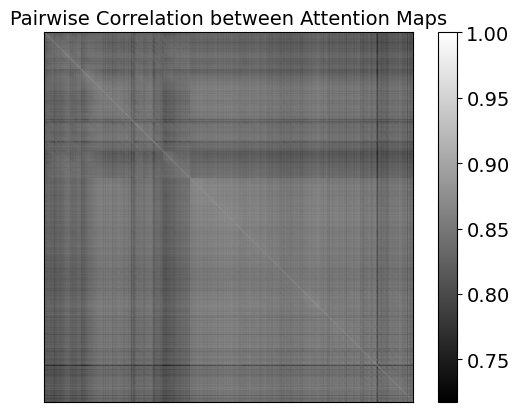

In [31]:
# compute pairwise correlation between attention maps
corr_matrix = np.corrcoef(state012)

plt.imshow(corr_matrix, cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Pairwise Correlation between Attention Maps')
plt.show()

In [9]:
state0 = attentions_by_state[0][0]
state1 = attentions_by_state[0][1]
state2 = attentions_by_state[0][2]
print(state0.shape, state1.shape, state2.shape)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']

state0_KK = []
for i in range(state0.shape[0]):
    experiment_KK = tools.multisession_NN_to_KK_1(
        [state0[0]],
        None,
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = tools.experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state0_KK.append(eval_KK)

state1_KK = []
for i in range(state1.shape[0]):
    experiment_KK = tools.multisession_NN_to_KK_1(
        [state1[0]],
        None,
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = tools.experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state1_KK.append(eval_KK)

state2_KK = []
for i in range(state2.shape[0]):
    experiment_KK = tools.multisession_NN_to_KK_1(
        [state2[0]],
        None,
        cell_type_order,
        all_sessions_new_cell_type_id,
    )
    eval_KK = tools.experiment_KK_to_eval_KK(experiment_KK, cell_type_order, eval_cell_type_order)
    state2_KK.append(eval_KK)

print(len(state0_KK), len(state1_KK), len(state2_KK))

(710, 527, 527) (672, 527, 527) (415, 527, 527)
710 672 415


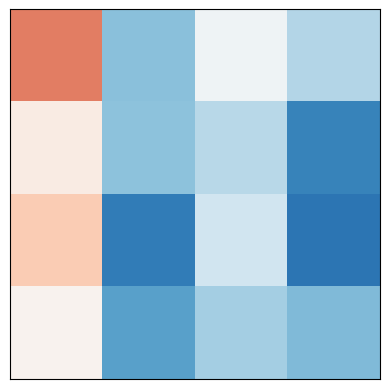

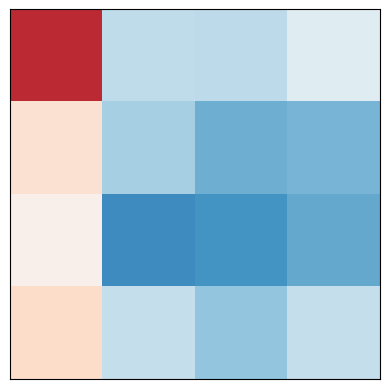

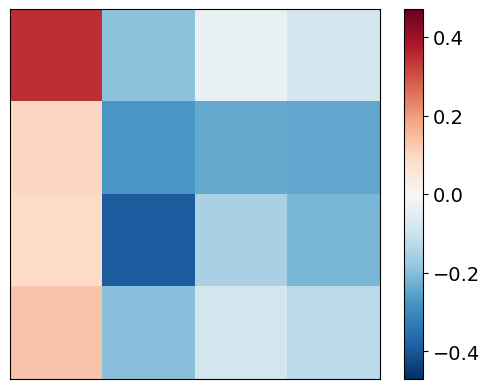

In [10]:
# Firt compute the mean KK for each state, and then do linear transformation

state0_KK_mean = np.mean(state0_KK, axis=0)
state1_KK_mean = np.mean(state1_KK, axis=0)
state2_KK_mean = np.mean(state2_KK, axis=0)

# linear transformation: apply the SAME linear transformation to all states

# flatten the matrix
flatten_matrix = np.concatenate([state0_KK_mean.flatten(), state1_KK_mean.flatten(), state2_KK_mean.flatten()])
flatten_GT = np.concatenate([KK_GT.flatten(), KK_GT.flatten(), KK_GT.flatten()])

# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(flatten_matrix, flatten_GT)
# linear transform
transformed_state0_KK = state0_KK_mean * slope + intercept
transformed_state1_KK = state1_KK_mean * slope + intercept
transformed_state2_KK = state2_KK_mean * slope + intercept

# Correct the sign
transformed_state0_KK = np.abs(transformed_state0_KK)
transformed_state0_KK[:, 1:] = -1 * transformed_state0_KK[:, 1:]
transformed_state1_KK = np.abs(transformed_state1_KK)
transformed_state1_KK[:, 1:] = -1 * transformed_state1_KK[:, 1:]
transformed_state2_KK = np.abs(transformed_state2_KK)
transformed_state2_KK[:, 1:] = -1 * transformed_state2_KK[:, 1:]

plt.imshow(transformed_state0_KK, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(transformed_state1_KK, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(transformed_state2_KK, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

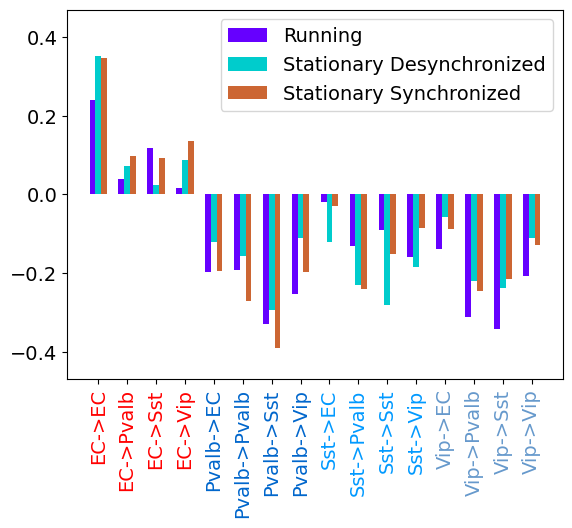

In [13]:
# Plot the flattened mean attention map of each state, there are 16 bars for each state
labels_16 = ['EC->EC', 'EC->Pvalb', 'EC->Sst', 'EC->Vip', 'Pvalb->EC', 'Pvalb->Pvalb', 'Pvalb->Sst', 'Pvalb->Vip', 'Sst->EC', 'Sst->Pvalb', 'Sst->Sst', 'Sst->Vip', 'Vip->EC', 'Vip->Pvalb', 'Vip->Sst', 'Vip->Vip']
N = 16
ind = np.arange(N)  
width = 0.2 

fig, ax = plt.subplots()
bar1 = ax.bar(ind - width, (transformed_state0_KK.T).flatten(), width, label='Running', color='#6600FF')
bar2 = ax.bar(ind, (transformed_state1_KK.T).flatten(), width, label='Stationary Desynchronized', color='#00CCCC')
bar3 = ax.bar(ind + width, (transformed_state2_KK.T).flatten(), width, label='Stationary Synchronized', color='#CC6633')
# ax.set_xlabel('Connection')
# ax.set_ylabel('Attention (mean)')
# ax.set_title('Averaged Attention Maps at Different States')
ax.set_xticks(ind)
ax.set_ylim(vmin_KK, vmax_KK)
xtick_labels = ax.set_xticklabels(labels_16, rotation=90)
for label in xtick_labels[:4]:
    label.set_color('red')
for label in xtick_labels[4:8]:
    label.set_color('#0066CC')
for label in xtick_labels[8:12]:
    label.set_color('#0099FF')
for label in xtick_labels[12:]:
    label.set_color('#6699CC')
ax.legend()
plt.show()

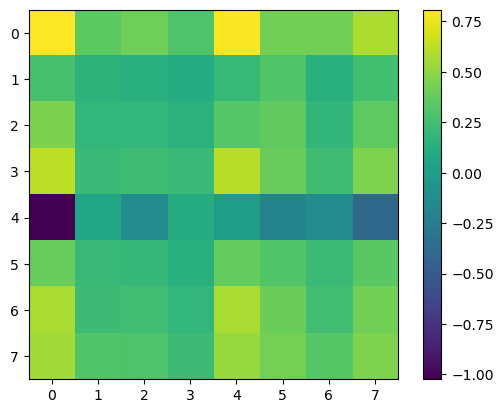

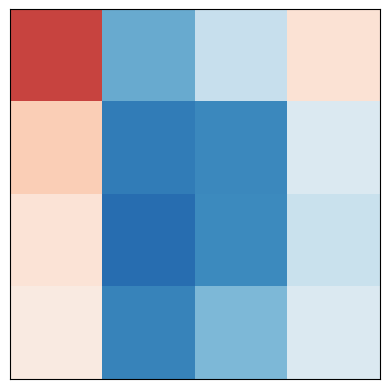

In [14]:
experiment_KK_strength = tools.multisession_NN_to_KK_1(
    all_sessions_avg_attention_NN, 
    None,
    cell_type_order,
    all_sessions_new_cell_type_id,
)

plt.imshow(experiment_KK_strength)
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength = tools.experiment_KK_to_eval_KK(experiment_KK_strength, cell_type_order, eval_cell_type_order)

transformed_eval_KK_strength = tools.linear_transform(eval_KK_strength, KK_GT)
plt.imshow(transformed_eval_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()

### Next Time-step Activity Prediction Performance on Real Data

Correlation:  PearsonRResult(statistic=0.7039766866450128, pvalue=0.0)
R squared:  0.4951591125322253


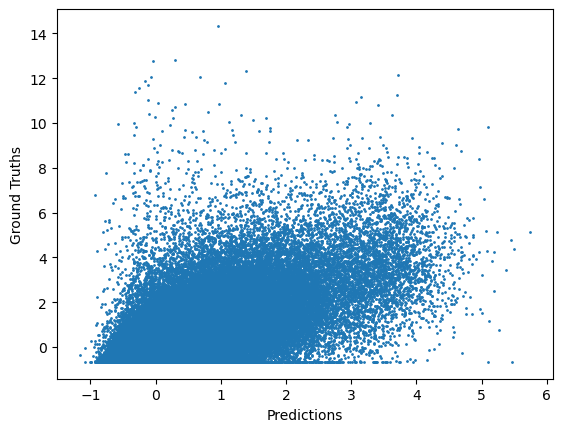

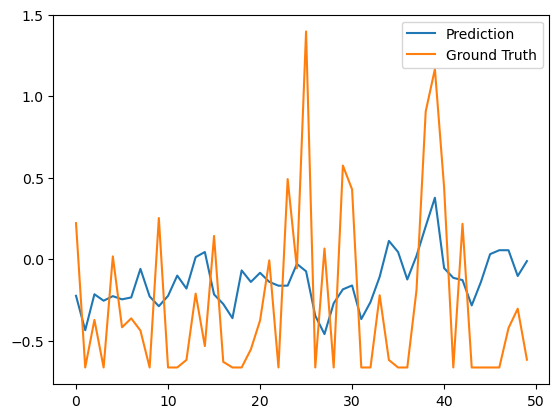

In [28]:
flatten_predictions = [predictions[0].flatten()]
flatten_ground_truths = [ground_truths[0].flatten()]

for i in range(1, num_session):
    flatten_predictions.append(predictions[i].flatten())
    flatten_ground_truths.append(ground_truths[i].flatten())

flatten_predictions = np.concatenate(flatten_predictions)
flatten_ground_truths = np.concatenate(flatten_ground_truths)

corr = stats.pearsonr(flatten_predictions, flatten_ground_truths)
R_squared = r2_score(flatten_ground_truths, flatten_predictions, multioutput='variance_weighted')

print("Correlation: ", corr)
print("R squared: ", R_squared)

plt.scatter(flatten_predictions, flatten_ground_truths, s=1)
plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

one_neuron_pred = predictions[0][:, 5, :]
one_neuron_gt = ground_truths[0][:, 5, :]

plt.plot(one_neuron_pred.flatten()[:50], label="Prediction")
plt.plot(one_neuron_gt.flatten()[:50], label="Ground Truth")
plt.legend()
plt.show()

(2481, 2481)


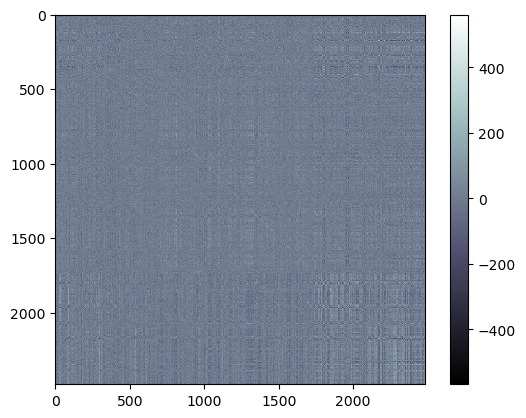

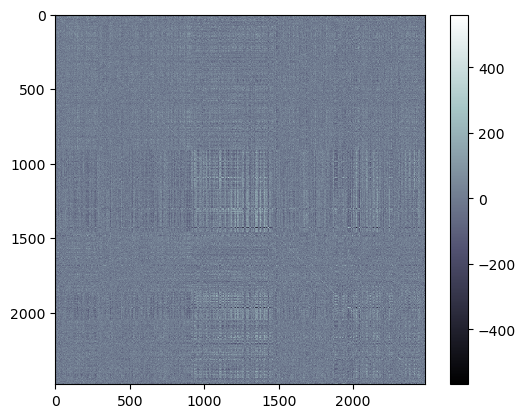

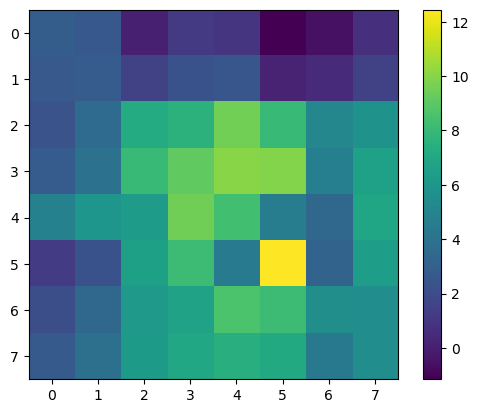

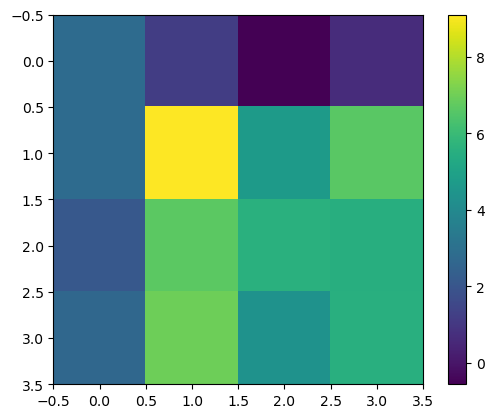

In [4]:
indices = torch.arange(num_unqiue_neurons)
neuron_embeddings = trained_model.embedding_table(indices).cpu().detach().numpy()

W_Q_W_KT = trained_model.attentionlayers[0][0].W_Q_W_KT.weight.cpu().detach().numpy()  # (out_dim, in_dim)
W_Q_W_KT = W_Q_W_KT.T  # (in_dim, out_dim)

result = neuron_embeddings @ W_Q_W_KT @ neuron_embeddings.T
print(result.shape)

plt.imshow(result, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

result = tools.group_connectivity_matrix_by_cell_type(result, neuron_id_2_cell_type_id)

plt.imshow(result, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

KK_result = tools.multisession_NN_to_KK_1(
    [result], 
    multisession_binary_NN_list=None, 
    cell_type_order=cell_type_order, 
    multisession_cell_type_id_list=[neuron_id_2_cell_type_id]
)

plt.imshow(KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_result = tools.experiment_KK_to_eval_KK(KK_result, cell_type_order, eval_cell_type_order)

plt.imshow(eval_KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

In [5]:
# loop through trainloader
results= []

for i, batch in enumerate(train_dataloader):
    x, neuron_ids, cell_type_ids = batch         # x is entire window
    x = x.squeeze(0)                 # remove the fake batch_size
    neuron_ids = neuron_ids.squeeze(0)
    cell_type_ids = cell_type_ids.squeeze(0)

    neuron_embeddings = trained_model.embedding_table(neuron_ids[0]).cpu().detach().numpy()
    result = neuron_embeddings @ W_Q_W_KT @ neuron_embeddings.T
    results.append(result)

713
6
(460, 460)
(178, 178)
(522, 522)
(497, 497)
(527, 527)
(495, 495)


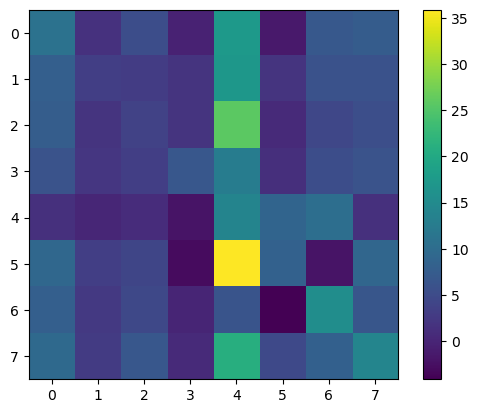

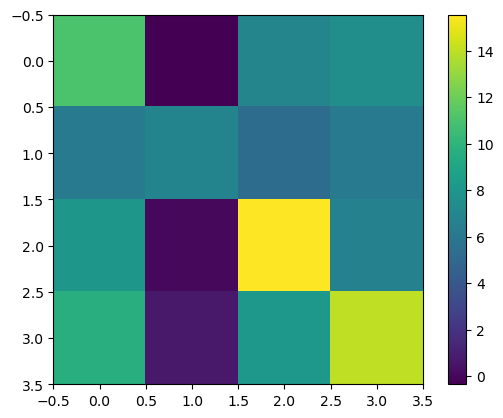

In [7]:
print(len(results))   # total number of batches for all sessions

all_session_results = []
accum = 0
for num in num_batch_per_session_TRAIN:
    all_session_results.append(results[accum])
    accum += num

print(len(all_session_results))
for i in range(len(all_session_results)):
    print(all_session_results[i].shape)


KK_result = tools.multisession_NN_to_KK_1(
    all_session_results, 
    multisession_binary_NN_list=None, 
    cell_type_order=cell_type_order, 
    multisession_cell_type_id_list=all_sessions_new_cell_type_id
)

plt.imshow(KK_result, interpolation='nearest')
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_result = tools.experiment_KK_to_eval_KK(KK_result, cell_type_order, eval_cell_type_order)

plt.imshow(eval_KK_result, interpolation='nearest')
plt.colorbar()
plt.show()